# Section 7
# Convolution, a smart way to do superpostion

IHE, transient groundwater

Olsthoorn, 2019-01-04

# Load modules and convenience functions

# Import functionality

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import exp1
from scipy.signal import lfilter
import pdb


# Convenience function to set up a graphic

def newfig(title='?', xlabel='?', ylabel='?', xlim=None, ylim=None,
                   xscale='linear', yscale='linear', size_inches=(14, 8), fontsize=15):
    '''Setup a new axis for plotting'''
    fig, ax = plt.subplots()
    fig.set_size_inches(size_inches)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if xscale: ax.set_xscale(xscale)
    if yscale: ax.set_yscale(yscale)
    if xlim: ax.set_xlim(xlim)
    if ylim: ax.set_ylim(ylim)
    ax.grid(True, which='both')

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                     ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fontsize)
    return ax

def clr_gen():
    """Yield next color."""
    clrs = ['b', 'r', 'g', 'k', 'm', 'c']
    for i in range(100):
        yield clrs[i % len(clrs)]
        
def mrk_gen():
    """Yield next marker."""
    mrks = ['o', 's', '^', 'v', 'x', '*']
    for i in range(100):
        yield mrks[i % len(mrks)]
        
def ls_gen():
    """Yield next line style."""
    lss = ['-', '--', '-.', '..']
    for i in range(100):
        yield lss[i % len(lss)]
        
        
        
        

# Convolution

Convolution is a smart way to do superpostion, in space as well as in time. But mostly we'll use it with respect to time. Convolution is used to obtain the head or discharge at some time due to an arbitrarily varying input in the past.

Imagine that the past input, e.g. the well extraction, to be approximated as adjacent pieces, each constant during a given time unit $d\tau$. Then the result, i.e. the head/drawdown or discharge at time $t$ due to intput happening between $t-(\tau - d\tau)$ and $t - \tau$ in the past can be computed by superposition

$$ s = p(t - (\tau + d\tau)) \left( R_s(\tau + d\tau) - R_s(\tau) \right)$$

where $p(t - (\tau + d\tau) $ is the constant input $p$, i.e. the well extraction, between $t - (\tau + d\tau)$ and $t - \tau$ and in which $R_s(..)$ is the so-called step response, i.e. the response to a constant unit extraction $p=1$ for $t>0$, while $p=0$ for $t<=0$ 

To obtain the total response of the input we have, when we assume that all $d\tau$ are constant, i.e. that the time axis is divided into equal time intervals of length $d\tau$: 

$$ s = \sum _{i=0} ^\infty \left\{p(t - (i+1) d\tau) \left( R_s((i+1) d\tau) - R_s(i d\tau) \right) \right\} $$


The interesting thing is, that most analytical solutions are in fact step responses. Like the solution for a sudden head change at the edge of a strip of land and the solution for a well that starts extracting at a constant rate.

For example the Theis solution for a well in a uniform aquifer of infinite extent, when devided by $Q$, or with $Q=1$ for that matter, is a step response

$$ R_s(\tau) = \frac {s(r, \tau)} Q  = \frac 1 {4 \pi kD} \mbox{W}(u), \,\,\,\, u = \frac {r^2 S} {4 kD \tau} $$

So with Theis well function, $W(-)$, i.e. the exponential integral, which is $\mathtt{exp1}(..)$ in the module `scipy.spcecial`, we have as the step response for a Theis well

$$ R_s(\tau) = \frac {\mathtt{exp1}(\frac {r^2 S} {4 kD \tau})} {4 \pi kD} $$

Let's, for convenience call, the second factor in the sum expression the `block response` $B(\tau)$. Then

$$ s = \sum _{i=0} ^\infty \left\{p(t - (i+1) d\tau) \, B_r(i \, \tau, d\tau) \right\} $$


This expression can be viewed graphically bin alining the $\tau$ axis backward from the considered time $t$ along the time axis of the input $p(t)$ and then multiplying the corresponding values and summing the result.

This summation (convolution / filtering) is readily done with `scipy.signal.lfilter(..)`.

## We use peason 3 as a general impulse response function for illustration purposes

$$f(x, \kappa) = \frac{|\beta|}{\Gamma(\alpha)}
                 (\beta (x - \zeta))^{\alpha - 1}
                 \exp(-\beta (x - \zeta))$$
                 
$$\beta = \frac{2}{\kappa}$$
        $$\alpha = \beta^2 = \frac{4}{\kappa^2}$$
        $$\zeta = - \frac{\alpha}{\beta}=-\beta$$
        
$\Gamma$ is the gamma function (scipy.special.gamma). Pass the skew $\kappa$ into pearson3 as the shape parameter `skew`.

The pdf is in "standardized" from. To shift and or scale the distribution use the `loc` and `scale` parameters. Specifically `pearson3.pdf(x, skew, loc, scale)` is directly equivalent to `pearson3.pdf(x, skew) / scale` with `y = (x - loc) / scale`.


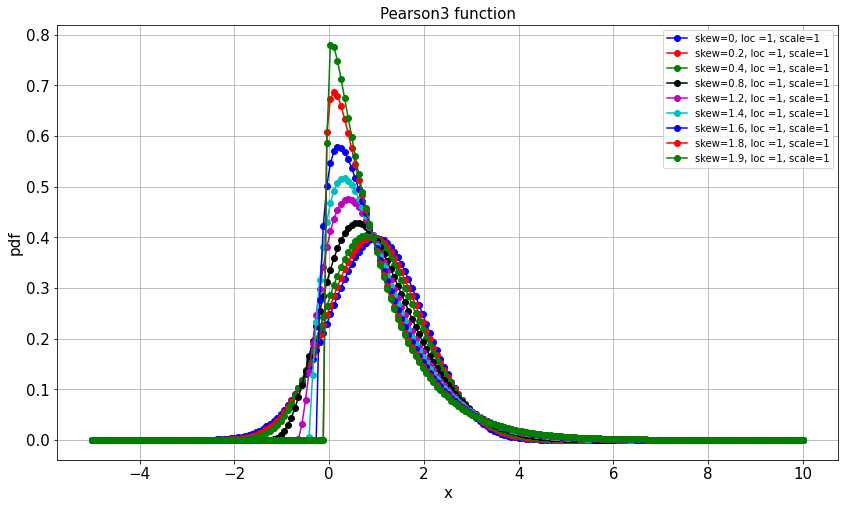

In [116]:
from scipy.stats import pearson3
from scipy.special import gamma

ax = newfig("Pearson3 function", "x", "pdf", yscale='linear')

xpars = (-5, 10, 201)
skews = 0, 0.2, 0.4, 0.8, 1.2, 1.4, 1.6, 1.8, 1.9
locs = 0, 1, 2
scales = 1, 2, 4

locs = [1]
scales = [1]

clrs = clr_gen()

x = np.linspace(*xpars)
for skew in skews:
    clr = next(clrs)
    mrks = mrk_gen()
    for loc in locs:
        mrk = next(mrks)
        lss = ls_gen()        
        for scale in scales:
            ls = next(lss)
            ax.plot(x, pearson3.pdf(x, skew, loc, scale),
                    color=clr, ls=ls, marker=mrk,
                    label='skew={}, loc ={}, scale={}'.format(skew,loc,scale))
ax.legend()

plt.show()


# Scaled Gamma distribution

Jos von Asmuth uses the scaled gamma distribution to fit impulse responses. He relatres this distribution to the reaction of a series of $n$ linear reservoirs, where $n$ does not have to be an integer, but $n=1$ is the impulse response for a single linear reservoir.

$$\theta(t)=A \frac{a^n t^{n-1}\exp(-at)}{\Gamma(n)},\,\,\,\,\,t\ge0$$
and
$$\theta(t)=0,\,\,\,\,\,t<0$$


$A$ is the area under the scaled gamma distribution. It is the reatio of the mean convectivity of the groundwater head above the base to the mean groundwater recharge. This definition equals that of the drainage resistance.

For a single reservoir, $n=1$ the SG distribution reduces to (note $\Gamma(1)=1$):

$$\theta(t, n=1) = A \,a \exp(-at)$$

So that $Aa$ then is the value at $t=0$ and $a$ is the factor in a pure exponential decaying process and shows the rate of decay. In such a reservoir, we would have $\theta(0) = \frac{P}{\mu} = A a$ in which $P$ is the water of a shower that immedately hits the water table and $\mu$ the storage coefficient (specific yield). Hence
$$ \frac{P=1}{\mu} = A a \rightarrow A = \frac{1}{a \mu} [T]$$

In [181]:
def sg_pdf(t, A=1., a=10., n=1, b=0):
    """Return scaled Gamma distribution.
    
    Used by Von Asmuth (2012) as a general shape for impulse response.
    
    Parameters
    ----------
    A: float
        Surface below distribution, scale factor.
    a: float
        Damping, T = 1/T in decaying process
    n: float
        Represents (absract) number of linear reservoirs
    b: float
        Delay
    """
    t = np.array([t]) if np.isscalar(t) else np.array(t)
    tau = t - b # time shift (delay)
    sg = np.zeros_like(t)
    sg[tau >= 0] = A * (a ** n) * (tau[tau >= 0] ** (n - 1)) * np.exp(- a * tau[tau >= 0]) / gamma(n)
    return sg

# Recreating fig 2.28 in Von Astmuth (2012)

## Fig 2.28 a

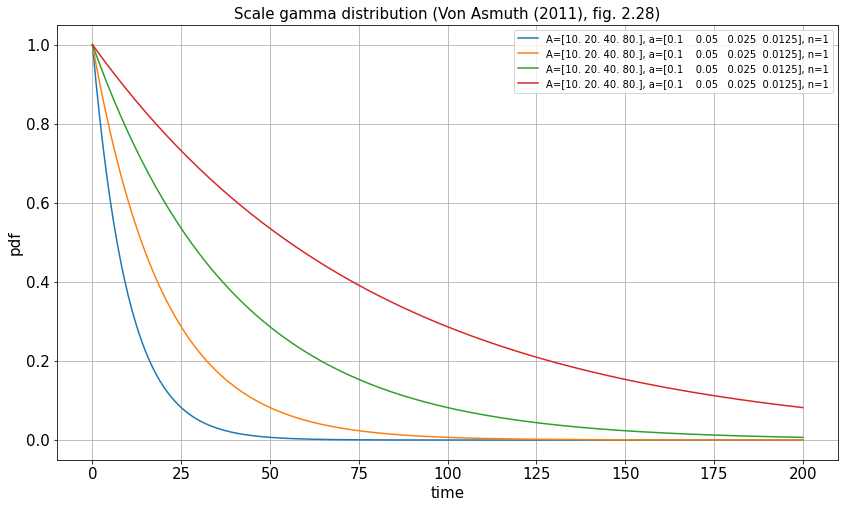

In [174]:
titles = "Scale gamma distribution (Von Asmuth (2011), fig. 2.28)", "time", "pdf"

ax = newfig(*titles)

tpars = 0, 200, 201

time = np.linspace(*tpars)


A = np.array([10., 20., 40., 80.])
a = 1 / A
n = 1

for A_, a_ in zip(A, a):
    ax.plot(time, sg_pdf(t=time, A=A_, a=a_, n=n), label="A={}, a={}, n={}".format(A, a, n))
ax.legend()
plt.show()

## Fig 2.28 b

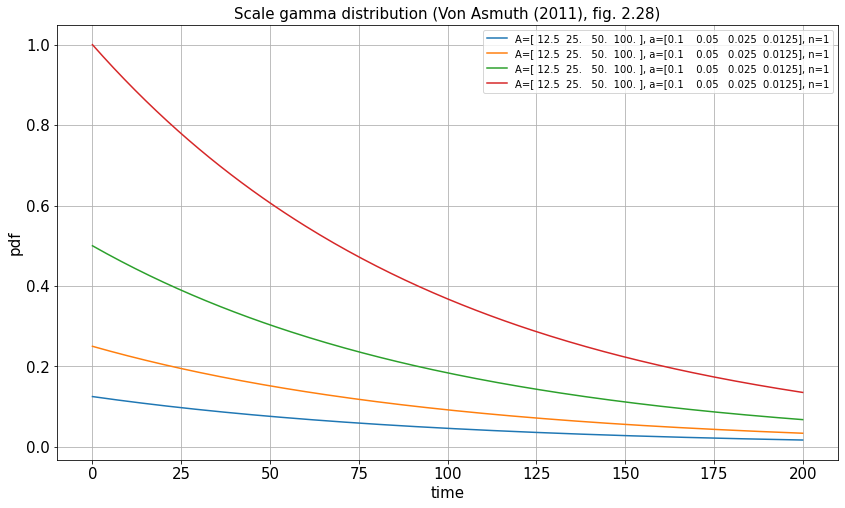

In [175]:
ax = newfig(*titles)

Aa = np.array([0.125, 0.25, 0.5, 1.0])
a_ = 0.01
A = Aa / a_
n = 1

for A_ in A:
    ax.plot(time, sg_pdf(t=time, A=A_, a=a_, n=n), label="A={}, a={}, n={}".format(A, a, n))
ax.legend()
plt.show()

## Fig 2.28 c

/Users/Theo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in power


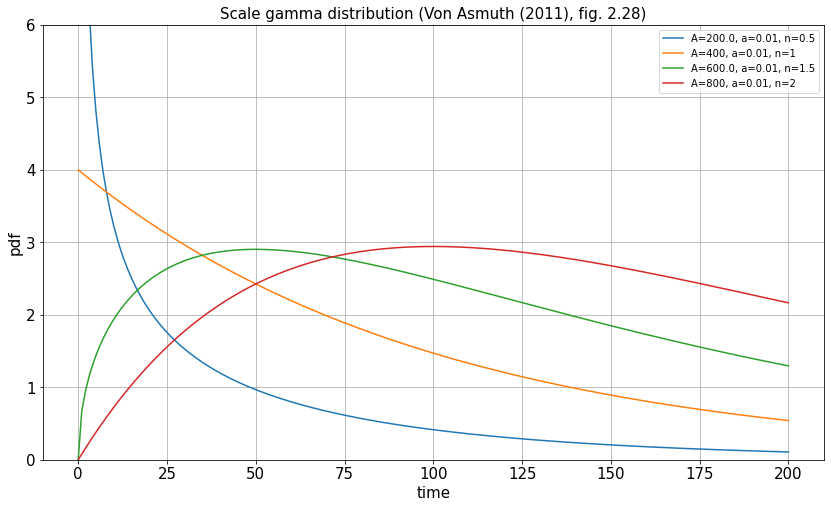

In [184]:
ax = newfig(*titles, ylim=(0, 6))

A_n = 400
a_ = 0.01
for n in [0.5, 1, 1.5, 2]:
    A_ = A_n * n
    ax.plot(time, sg_pdf(t=time, A=A_, a=a_, n=n), label="A={}, a={}, n={}".format(A_, a_, n))
    
ax.legend()
plt.show()

## Looking for a nice example impulse response

1. `A` merely sets the area under the distribution.
1. `a` set the damping, hence the speed of the decay of the head during free drainage
1. `n` sets the virtual number of reservoirs. n=1 is exponential. n<1 is faster than exponential, n>1 is slower than exponental and has a peak for t>0
1. `b` is pure the delay

/Users/Theo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in power
/Users/Theo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in power


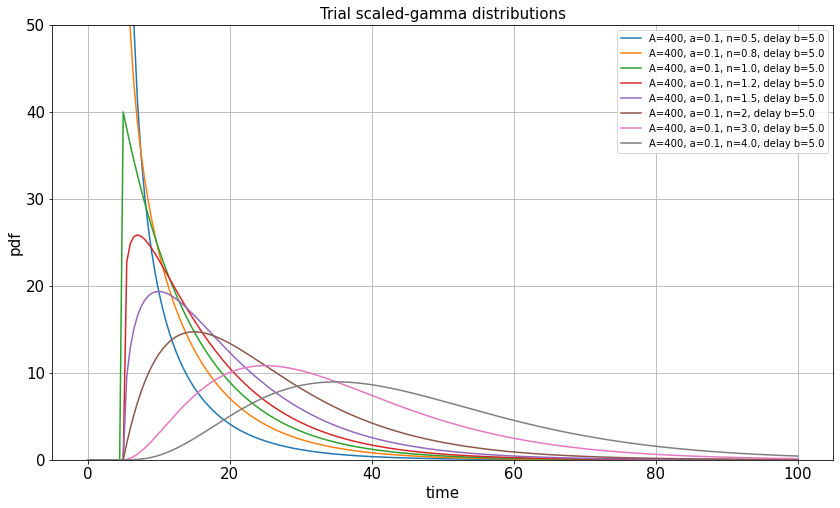

In [211]:
ax = newfig('Trial scaled-gamma distributions', 'time', 'pdf', ylim=(0, 50))

tpars = 0, 100, 201
time = np.linspace(*tpars)

A_ = 400
a_ = 0.1
b = 5.0
for n in [0.5, 0.8, 1.0, 1.2, 1.5, 2, 3., 4.]:
    ax.plot(time, sg_pdf(t=time, A=A_, a=a_, n=n, b=b), label="A={}, a={}, n={}, delay b={}".format(A_, a_, n, b))
    
ax.legend()
plt.show()

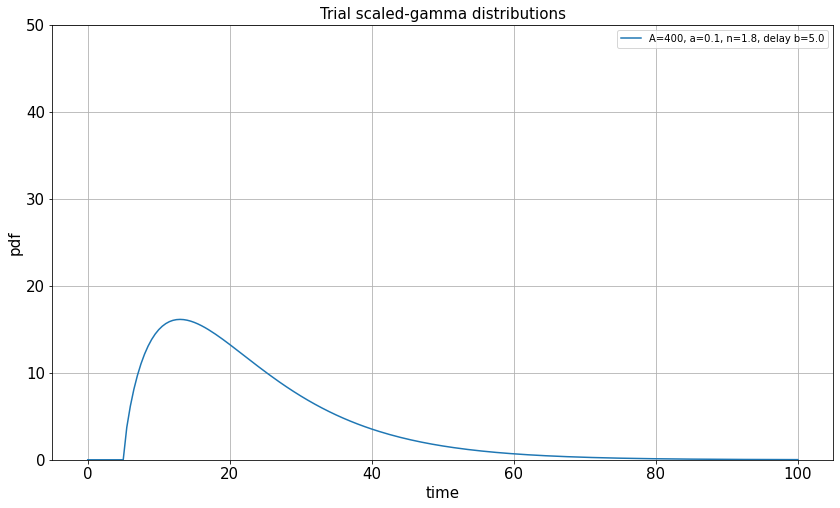

In [215]:
ax = newfig('Trial scaled-gamma distributions', 'time', 'pdf', ylim=(0, 50))

tpars = 0, 100, 201
time = np.linspace(*tpars)

A_ = 400
a_ = 0.1
b = 5.0
for n in [1.8]:
    ax.plot(time, sg_pdf(t=time, A=A_, a=a_, n=n, b=b), label="A={}, a={}, n={}, delay b={}".format(A_, a_, n, b))
    
ax.legend()
plt.show()

# Lognormal distribution `scipy.stats.lognorm()`

$$f(x,s) = \frac{1}{s x \sqrt{2 \pi}} \exp\left(-\frac{\log^2(x)}{2 s^2}\right)$$

The lognormal distribution always starts at 0. For $s < 1$, the pdf becomes more and more similar to a normal distribution centered at $x = 1$.

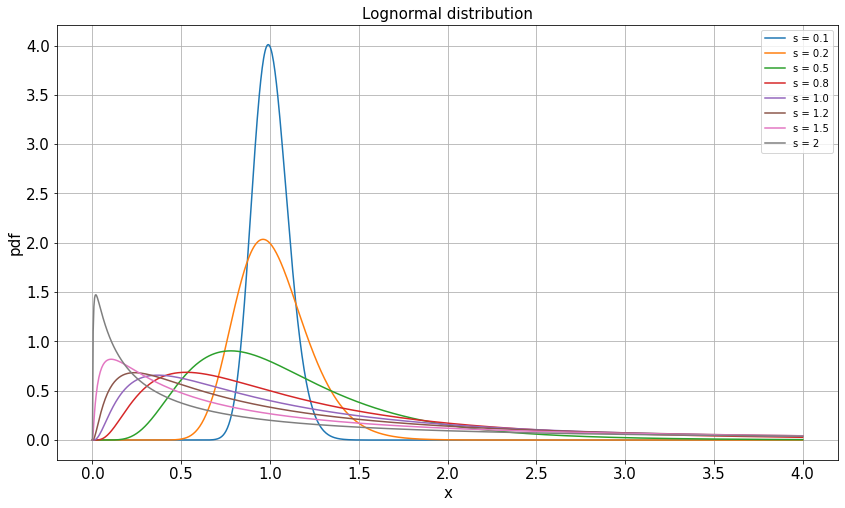

In [233]:
from scipy.stats import lognorm

ax = newfig("Lognormal distribution", "x", "pdf")

xpars = 0, 4, 1001

x = np.linspace(*xpars)

loc   = 0  # location, in fact a delay
scale = 1  # The area under the pdf is 1/scale. Scale is in facto exp(mu)
s = [0.1, 0.2, 0.5, 0.8, 1.0, 1.2, 1.5, 2] # shapes, in fact the standard deviation.

for s_ in s:
    ax.plot(x, lognorm.pdf(x, s_, loc, scale), label='s = {}'.format(s_))
ax.legend()

# Using sigma and mu of the normal distribution

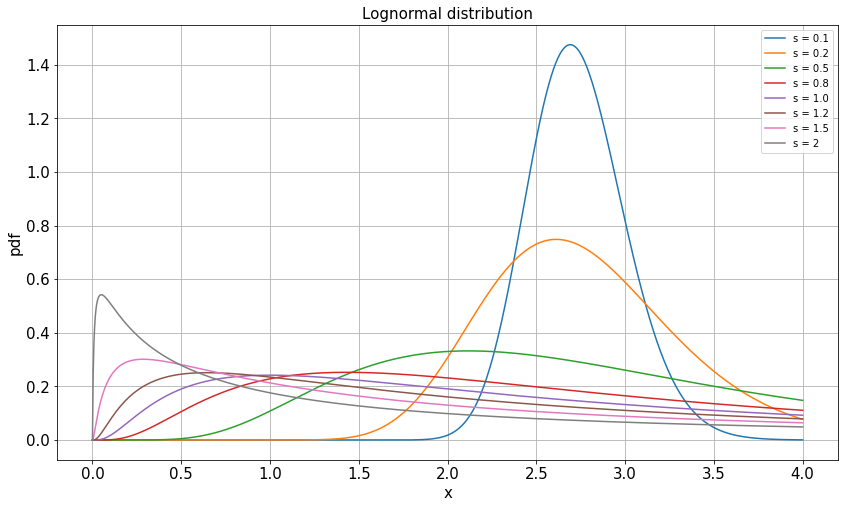

In [234]:
ax = newfig("Lognormal distribution", "x", "pdf")

xpars = 0, 4, 1001

x = np.linspace(*xpars)

mu = 1.0
loc   = 0  # location, in fact a delay
scale = np.exp(mu)  # The area under the pdf is 1/scale. Scale is in facto exp(mu)
sigma = [0.1, 0.2, 0.5, 0.8, 1.0, 1.2, 1.5, 2] # shapes, in fact the standard deviation.

for s_ in sigma:
    ax.plot(x, lognorm.pdf(x, s_, loc, scale), label='s = {}'.format(s_))
ax.legend()

# Simulate the drawdown development of a transient well in a confined aquifer (Theis) whe the well extraction is varying in an abitrary fashion

In [69]:
# drawdown by convolution
# compute the time series response to each well at the given r
def dd(B, Q):
    """Return the drawdown computed by convolution.
    
    Parameters
    ----------
    B: ndarray
        block response (unit extraction during dtau).
    Q: ndarray
        extraction from the (Theis) well
    """
    return lfilter(B, 1, Q)

# aquifer data
S  = 0.001 # [-]
kD = 600 # m2/d
r  = 1000. # m

# time step length
dtau = 1

# Length of time series taken as long as the length of the block response
tau = np.arange(1, 100, dtau)

def step(r):
    """Compute and return step response.
    
    The step response is here the drawdowndue to a Theis well with unit extraction (i.e. 1 m3/d).
    """
    u = r**2 * S /(4 * kD * tau)
    return 1 / (4 * np.pi * kD) * np.hstack((0, exp1(u))) # Starts at zero at t=zero

def block(r):
    """Compute and return block response."""
    stp = step(r)
    return np.diff(stp)

# Time series data (extaction)
# modify extraction time series of well 1 to a simpler one to more easily interprete the result

# Well 1 extraction time series with noise
nstep = len(tau) - 1
Q1 = np.zeros(nstep)
Q1[:] = -800; Q1[:80] = -100; Q1[:30] = -500

# Well 2 extraction time series
Q2   = Q1 + 300 * (np.random.rand(nstep) - 0.5)

# time axes, arbitrary, one can use dates as well
time = 100. + tau

## Convolution by means of `scipy.signal.lfilter(..)`

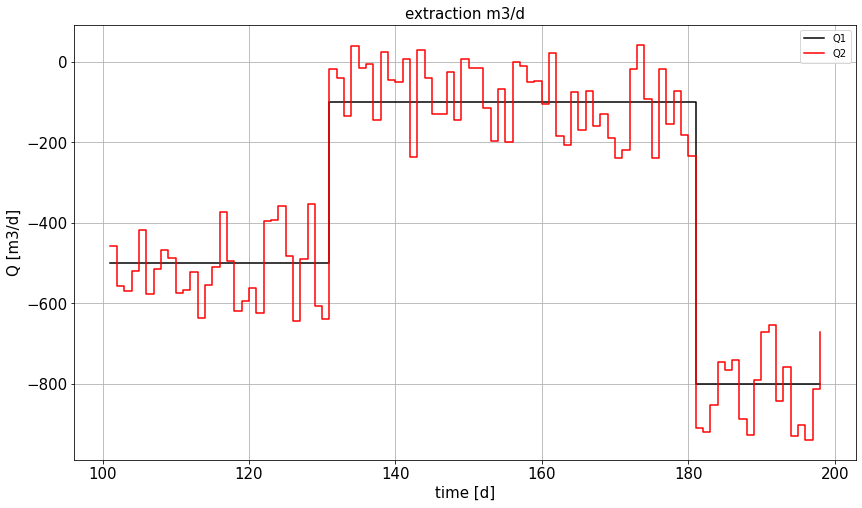

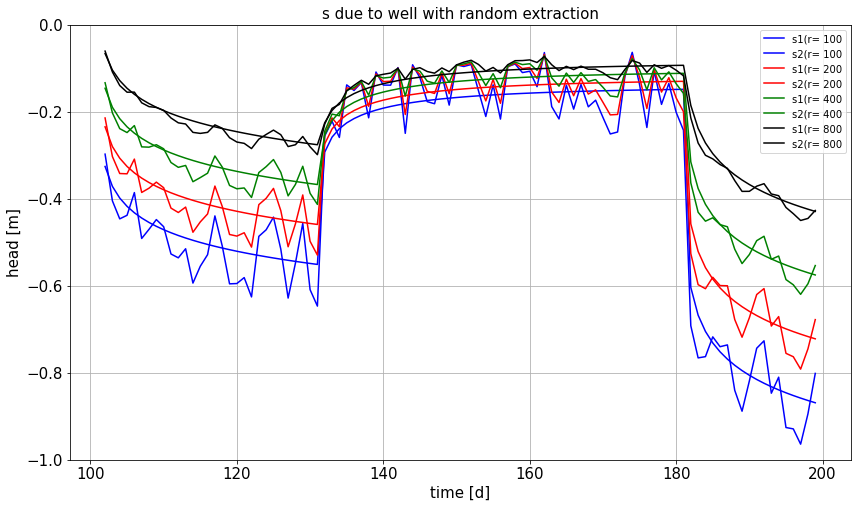

In [70]:
# show graph of the input
ax = newfig('extraction m3/d', 'time [d]', 'Q [m3/d]')

ax.step(time[:-1], Q1, 'k', label='Q1', where='post')
ax.step(time[:-1], Q2, 'r', label='Q2', where='post')
ax.legend()
plt.show()

# show the result, i.e. the head change caused by the varying extraction
ax = newfig('s due to well with random extraction', 'time [d]', 'head [m]', ylim=(-1, 0))

color = clr_gen()

for r in [100, 200, 400, 800]:
    B = block(r)
    clr = next(color)
    ax.plot(time[1:], dd(B, Q1), clr, label='s1(r={:4.0f}'.format(r))
    ax.plot(time[1:], dd(B, Q2), clr, label='s2(r={:4.0f}'.format(r))
ax.legend()

## Compare the result for well s1 with regular superposition

We can obtain the same results by means of regular superpostion. We'll show this on the hand of the input of well Q1, which is less random, and so easier to compare.

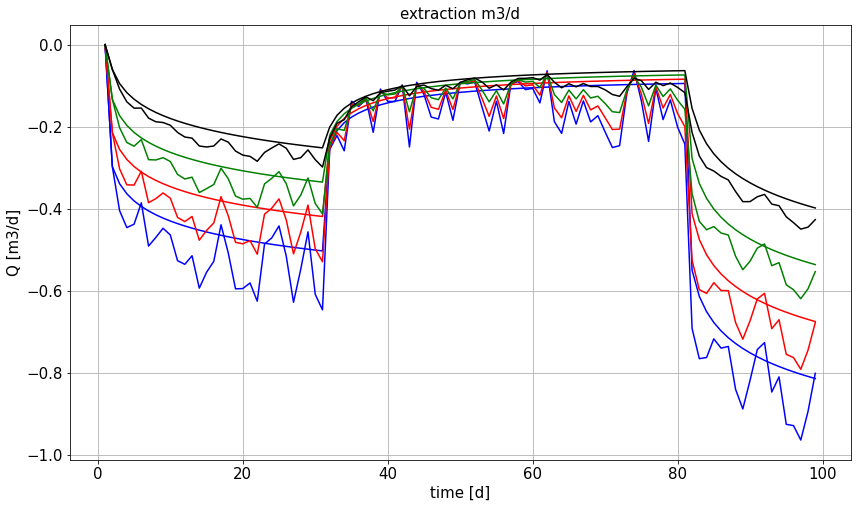

In [78]:
tchange = tau # Times at which the extraction changes (in fact for this test at each time)

dQ1 = np.hstack((Q2[0], np.diff(Q1)))
dQ2 = np.hstack((Q2[0], np.diff(Q2)))

# show graph of the input
ax = newfig('extraction m3/d', 'time [d]', 'Q [m3/d]')

color = clr_gen()

for r in [100, 200, 400, 800]:
    clr = next(color)
    s1 = np.zeros_like(tau, dtype=float)
    s2 = np.zeros_like(tau, dtype=float)
    for tch, dQ1_, dQ2_ in zip(tchange, dQ1, dQ2):
        u = r ** 2 * S / (4 * kD * (tau[tau > tch] - tch))
        s1[tau > tch] += dQ1_ / (4 * np.pi * kD) * exp1(u)
        s2[tau > tch] += dQ2_ / (4 * np.pi * kD) * exp1(u)
    ax.plot(tau, s1, clr, label='s1(r = {:4.0f})'.format(r))
    ax.plot(tau, s2, clr, label='s1(r = {:4.0f})'.format(r))


# Just print out the above to see what has been obtained in each step.

What follows next is ordinary superposition in time

In [73]:
type(s1[0])

numpy.int64

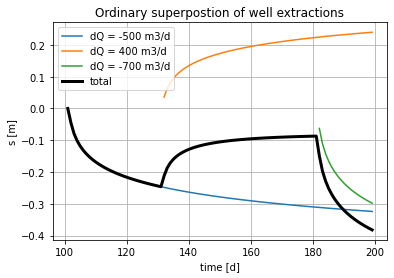

In [7]:
plt.title("Ordinary superpostion of well extractions")
plt.xlabel('time [d]')
plt.ylabel('s [m]')
plt.grid()

s = np.zeros_like(time)

# loop over the switch times and the flow changes
for st, dq in zip(swt, dQ): 
    I = time > st   # select the time points that are later than the current switch times

    # compute the head changes for these times
    s_ = dq /(4 * np.pi * kD) * exp1(r**2 * S / (4 * kD * (time[I] - st)))
    plt.plot(time[I], s_, label='dQ = {:.0f} m3/d'.format(dq))

    # add them to the total head changes
    s[I] += s_
    
plt.plot(time, s, 'k', lw=3, label='total')
plt.legend()
plt.show()

As can be seen by comparing the graphs, the superposition yields the same results as the convolution, however, the convolution is more straight forward and simpler if the extraction varies truly randomly.

## Bibliography

Olsthoorn, T.N. (2008) Do a bit more with convolution. Groundwater Journal. Vol. 46 No. 1, 13-22